# Model C: Stage Classification (1 vs 2 vs 3)

Multi-class classification to distinguish between Stage 1, Stage 2, and Stage 3.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

In [39]:
# Load Data
df = pd.read_csv('cirrhosis.csv')

# Drop ID
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

df = df.dropna(subset=['Stage'])

# Filter: Only Stages 1, 2, 3 (no Stage 4)
df_c = df[df['Stage'].isin([1, 2, 3])].copy()

print(f"Filtered Shape (Stages 1,2,3 only): {df_c.shape}")
print("\nStage Distribution:")
print(df_c['Stage'].value_counts().sort_index())

Filtered Shape (Stages 1,2,3 only): (25000, 19)

Stage Distribution:
Stage
1    8265
2    8441
3    8294
Name: count, dtype: int64


## 1. Target Definition
**Multi-class: Stage 1 vs Stage 2 vs Stage 3**

In [40]:
# Target: Stage as-is (1, 2, 3)
# Adjust to 0, 1, 2 for sklearn
df_c['Stage_Class'] = df_c['Stage'] - 1  # 1→0, 2→1, 3→2

print("Multi-class Target Distribution (Model C):")
print(df_c['Stage_Class'].value_counts().sort_index())
print(f"\nClass 0 (Stage 1): {(df_c['Stage_Class'] == 0).sum()}")
print(f"Class 1 (Stage 2): {(df_c['Stage_Class'] == 1).sum()}")
print(f"Class 2 (Stage 3): {(df_c['Stage_Class'] == 2).sum()}")

Multi-class Target Distribution (Model C):
Stage_Class
0    8265
1    8441
2    8294
Name: count, dtype: int64

Class 0 (Stage 1): 8265
Class 1 (Stage 2): 8441
Class 2 (Stage 3): 8294


## 2. Log Transformation + Winsorization

In [41]:
# Log Transformation + Winsorization
log_transform_cols = ['Bilirubin', 'Copper', 'Alk_Phos', 'Tryglicerides', 'SGOT', 'Prothrombin', 'Cholesterol']

print("Step 1: Applying Log Transformation...")
df_transformed_c = df_c.copy()
for col in log_transform_cols:
    if col in df_transformed_c.columns:
        df_transformed_c[col] = np.log1p(df_transformed_c[col])
        print(f"  - {col}: log-transformed")

winsor_cols = log_transform_cols

# Apply Stage-Specific Winsorization
clipped_df = df_transformed_c.copy()
stages = clipped_df['Stage'].unique()

print("\nStep 2: Applying Stage-specific Winsorization...")
for stage in stages:
    stage_mask = (clipped_df['Stage'] == stage)
    for col in winsor_cols:
        if col in clipped_df.columns:
            stage_data = clipped_df.loc[stage_mask, col]
            Q1 = stage_data.quantile(0.25)
            Q3 = stage_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            clipped_df.loc[stage_mask, col] = stage_data.clip(lower=lower_bound, upper=upper_bound)
print("Winsorization complete!")

df_c_clean = clipped_df

Step 1: Applying Log Transformation...
  - Bilirubin: log-transformed
  - Copper: log-transformed
  - Alk_Phos: log-transformed
  - Tryglicerides: log-transformed
  - SGOT: log-transformed
  - Prothrombin: log-transformed
  - Cholesterol: log-transformed

Step 2: Applying Stage-specific Winsorization...
Winsorization complete!


## 3. Feature Engineering

In [42]:
def medical_feature_engineering(df_input):
    df_eng = df_input.copy()
    
    # Age conversion
    df_eng['Age_Year'] = df_eng['Age'] / 365.25
    
    # Unit conversions
    df_eng['bili_umolL'] = df_eng['Bilirubin'] * 17.1
    df_eng['alb_gL'] = df_eng['Albumin'] * 10
    df_eng['plt_1000uL'] = df_eng['Platelets'] / 1000
    
    # ALBI Score
    df_eng['ALBI'] = (np.log10(df_eng['bili_umolL']) * 0.66) + (df_eng['alb_gL'] * -0.085)
    
    # PALBI Score  
    df_eng['PALBI'] = (df_eng['ALBI'] * 1.0) + (df_eng['plt_1000uL'] * -0.04)
    
    # APRI
    df_eng['APRI'] = (df_eng['SGOT'] / 40) / df_eng['plt_1000uL']
    
    # FIB-4
    df_eng['FIB4'] = (df_eng['Age_Year'] * df_eng['SGOT']) / (df_eng['plt_1000uL'] * np.sqrt(df_eng['Bilirubin']))
    
    # Bilirubin/Platelets
    df_eng['Bili_Platelet_Ratio'] = df_eng['Bilirubin'] / (df_eng['Platelets'] + 1)
    
    # Copper×Bilirubin
    df_eng['Copper_Bili_Interaction'] = df_eng['Copper'] * df_eng['Bilirubin']
    
    return df_eng

df_c_fe = medical_feature_engineering(df_c_clean)
print("Medical features engineered!")
print(df_c_fe[['ALBI', 'PALBI', 'APRI', 'FIB4']].describe())

Medical features engineered!
               ALBI         PALBI          APRI          FIB4
count  25000.000000  25000.000000  25000.000000  25000.000000
mean      -2.165252     -2.175493      0.549604   1168.146313
std        0.407392      0.407997      0.264423    655.555984
min       -3.394745     -3.409185      0.136059    203.331537
25%       -2.449781     -2.459981      0.376705    713.974544
50%       -2.178098     -2.191487      0.473866   1026.152029
75%       -1.931856     -1.942695      0.635118   1448.658409
max       -0.568093     -0.575693      2.287846   5507.561403


## 3.5. Exploratory Data Analysis (EDA)

EXPLORATORY DATA ANALYSIS - ALL FEATURES

Total numeric features: 21
Features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age_Year', 'bili_umolL', 'alb_gL', 'plt_1000uL', 'ALBI', 'PALBI', 'APRI', 'FIB4', 'Bili_Platelet_Ratio', 'Copper_Bili_Interaction']


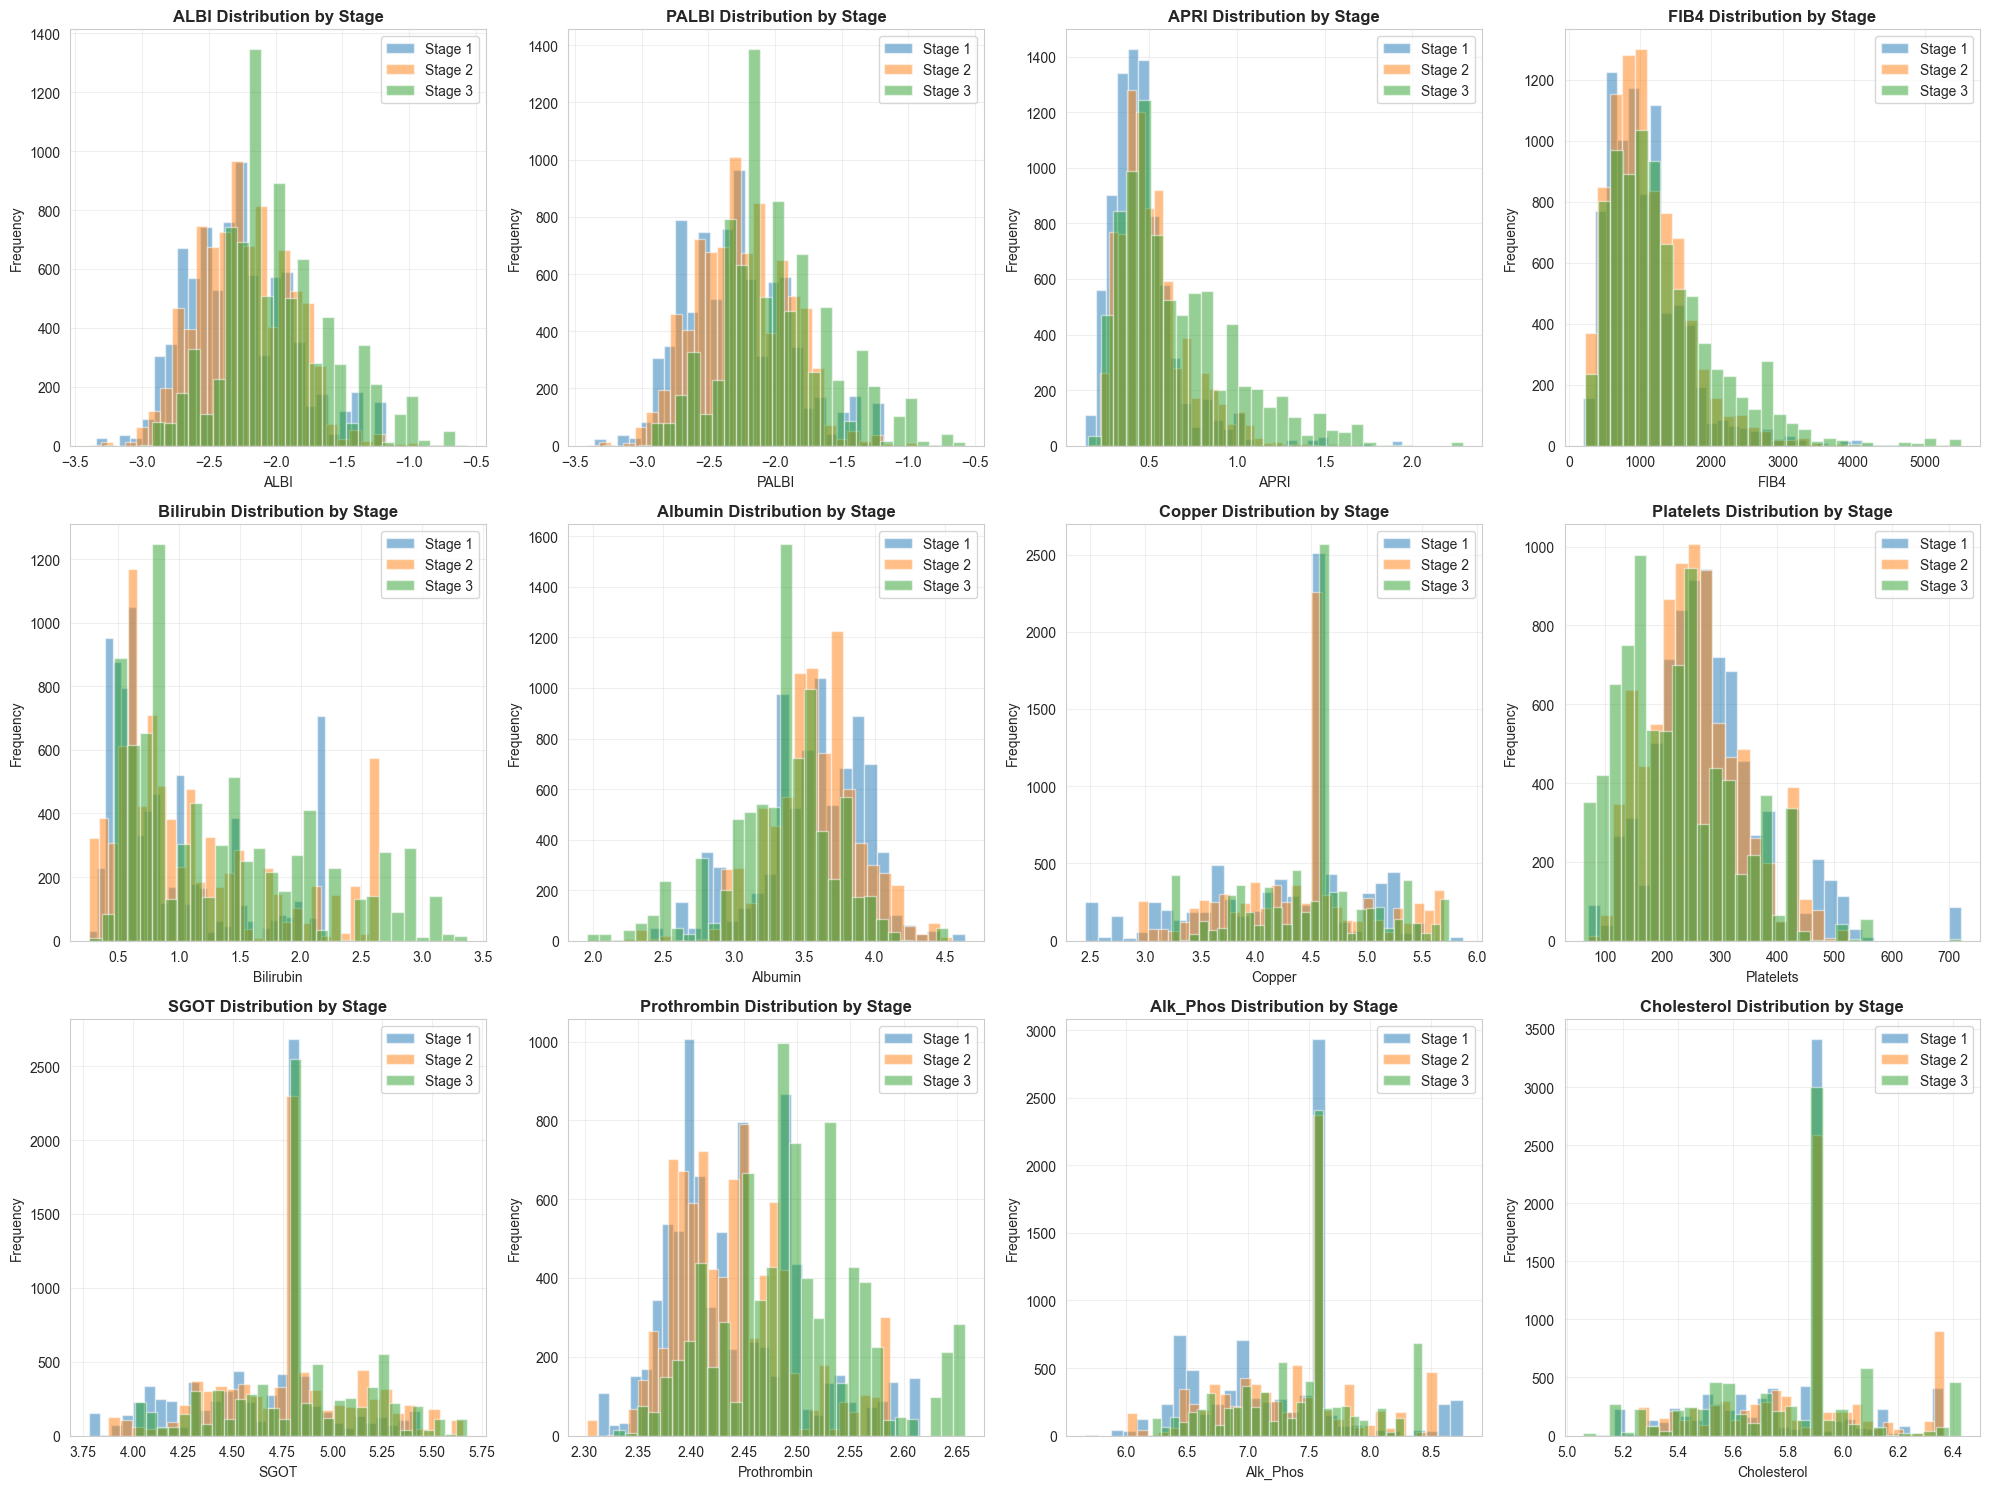


Correlation Analysis - Engineered Medical Features


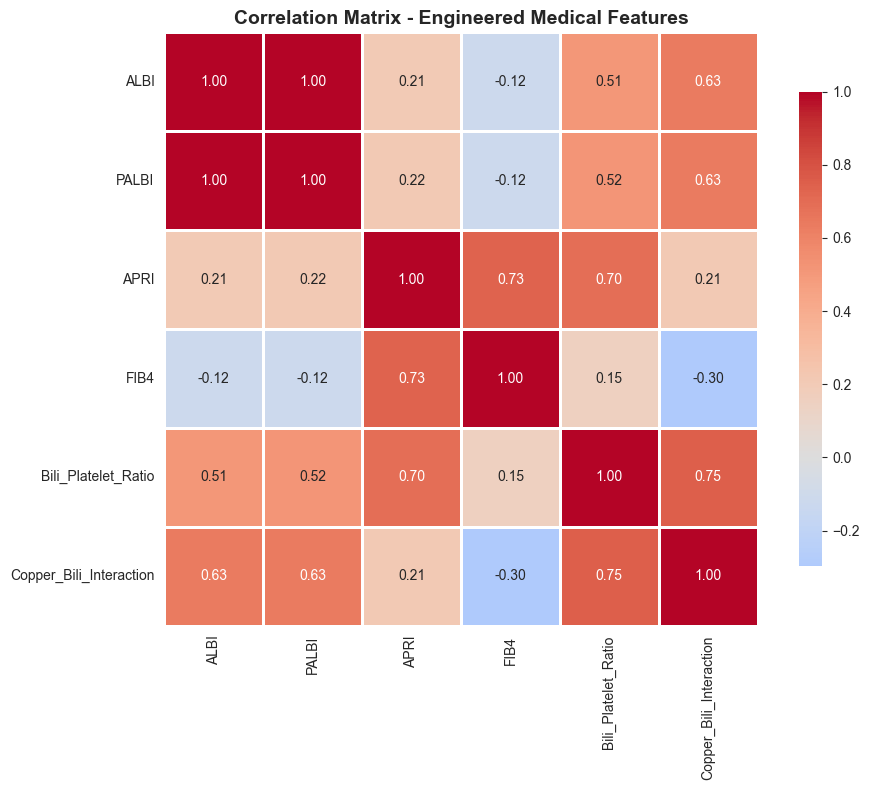

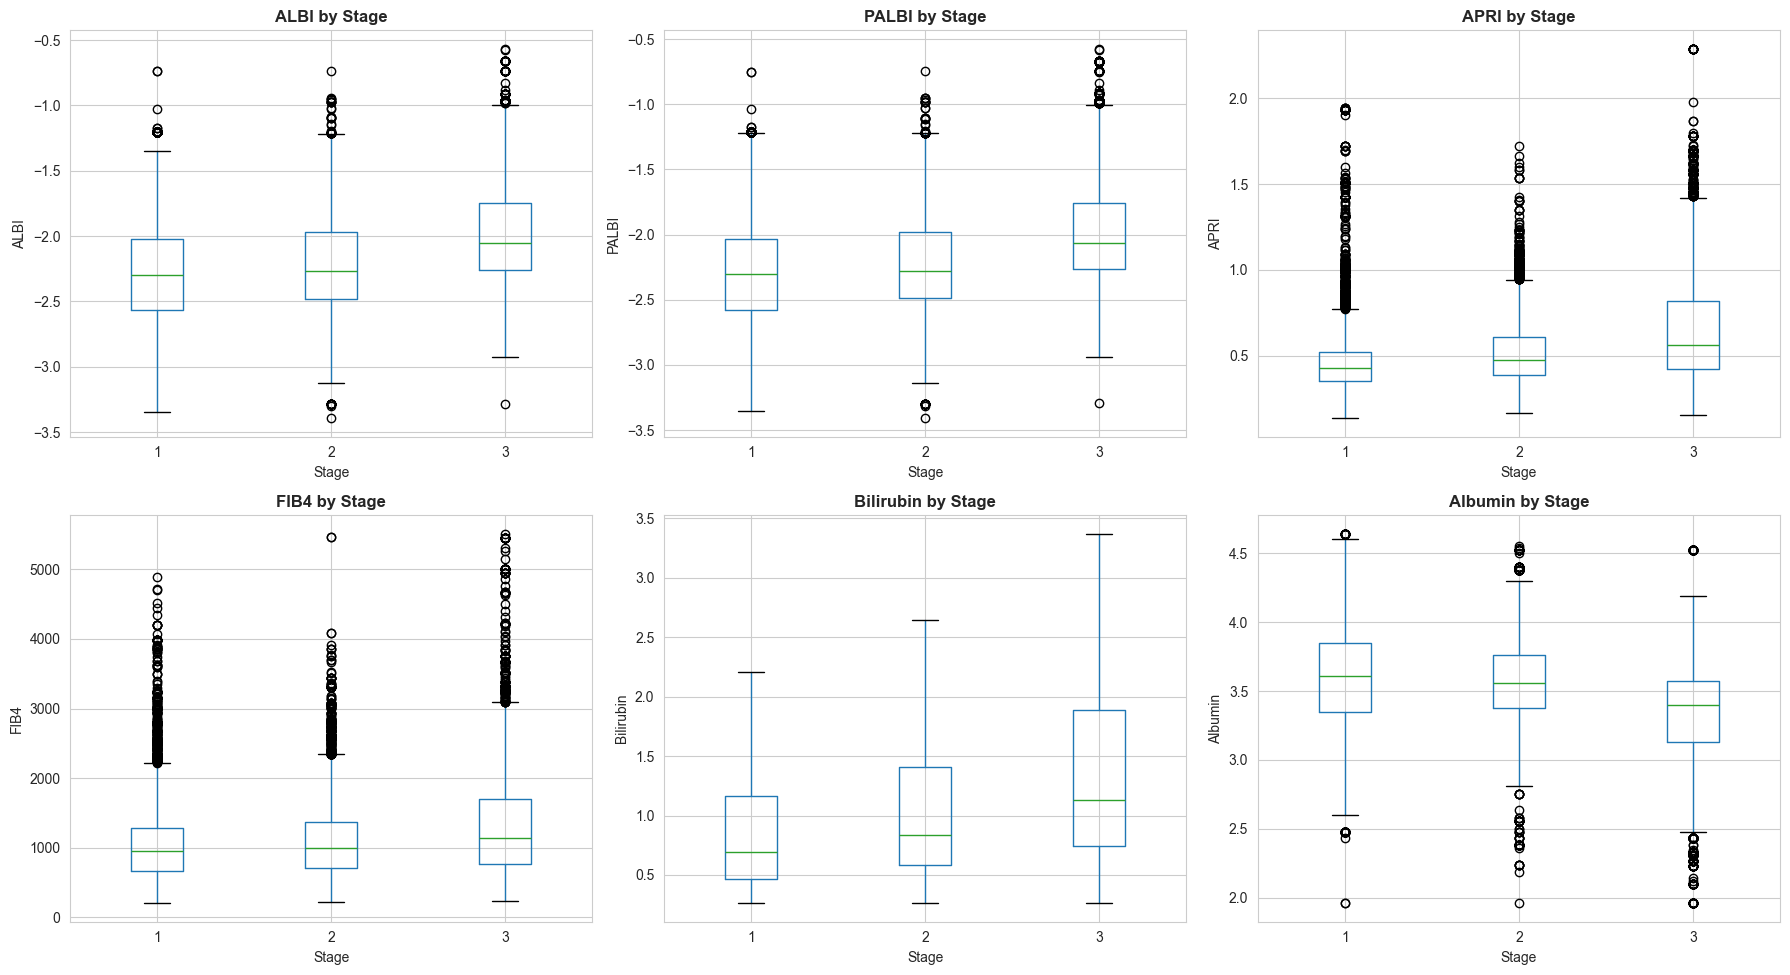


EDA Complete!


In [43]:
# EDA on All Features
print("="*70)
print("EXPLORATORY DATA ANALYSIS - ALL FEATURES")
print("="*70)

# Get all numeric features after feature engineering
numeric_features = df_c_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target and stage columns
numeric_features = [col for col in numeric_features if col not in ['Stage', 'Stage_Class', 'Target']]

print(f"\nTotal numeric features: {len(numeric_features)}")
print(f"Features: {numeric_features}")

# Distribution plots for key medical features
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

key_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bilirubin', 'Albumin', 
                'Copper', 'Platelets', 'SGOT', 'Prothrombin', 'Alk_Phos', 'Cholesterol']

for idx, feature in enumerate(key_features[:12]):
    if feature in df_c_fe.columns:
        for stage in [1, 2, 3]:
            stage_data = df_c_fe[df_c_fe['Stage'] == stage][feature].dropna()
            axes[idx].hist(stage_data, alpha=0.5, label=f'Stage {stage}', bins=30)
        axes[idx].set_title(f'{feature} Distribution by Stage', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap for engineered features
print("\nCorrelation Analysis - Engineered Medical Features")
engineered_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bili_Platelet_Ratio', 'Copper_Bili_Interaction']
if all(feat in df_c_fe.columns for feat in engineered_features):
    corr_matrix = df_c_fe[engineered_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Engineered Medical Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Box plots for stage comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

comparison_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bilirubin', 'Albumin']
for idx, feature in enumerate(comparison_features):
    if feature in df_c_fe.columns:
        df_c_fe.boxplot(column=feature, by='Stage', ax=axes[idx])
        axes[idx].set_title(f'{feature} by Stage', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Stage')
        axes[idx].set_ylabel(feature)
        axes[idx].get_figure().suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EDA Complete!")
print("="*70)


## 4. Preprocessing & Data Splitting

In [44]:
target_col = 'Stage_Class'
y = df_c_fe[target_col]

# Exclude intermediate, target, and treatment variables
drop_cols = ['Stage', 'Status', 'N_Days', 'Stage_Class', 'bili_umolL', 'alb_gL', 'Age', 'Age_Year', 'Drug', 'plt_1000uL']

X = df_c_fe.drop(columns=drop_cols)
y = df_c_fe[target_col]

# Handle Categorical
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Features: {X.shape[1]}")
print(f"Categorical: {len(categorical_cols)}, Numerical: {len(numeric_cols)}")

# Train/Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")
print(f"Train distribution:\n{y_train.value_counts().sort_index()}")
print(f"Test distribution:\n{y_test.value_counts().sort_index()}")

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

Features: 20
Categorical: 5, Numerical: 15

Train: (20000, 20), Test: (5000, 20)
Train distribution:
Stage_Class
0    6612
1    6753
2    6635
Name: count, dtype: int64
Test distribution:
Stage_Class
0    1653
1    1688
2    1659
Name: count, dtype: int64


## 5. Optuna Hyperparameter Tuning (Multi-class)

In [45]:
print("Starting Optuna Tuning for Multi-class Classification...")

# Random Forest
def objective_rf_c(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'class_weight': 'balanced'
    }
    model = RandomForestClassifier(**param, random_state=42, n_jobs=-1)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf_c, n_trials=10)
best_rf_params = study_rf.best_params
best_rf_params['class_weight'] = 'balanced'

# XGBoost
def objective_xgb_c(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'num_class': 3
    }
    model = XGBClassifier(**param, random_state=42, verbosity=0)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb_c, n_trials=10)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'use_label_encoder': False, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'num_class': 3})

# LightGBM
def objective_lgbm_c(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'class_weight': 'balanced',
        'objective': 'multiclass',
        'num_class': 3,
        'verbose': -1
    }
    model = LGBMClassifier(**param, random_state=42)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm_c, n_trials=10)
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'class_weight': 'balanced', 'objective': 'multiclass', 'num_class': 3, 'verbose': -1})

print("Best RF:", best_rf_params)
print("Best XGB:", best_xgb_params)
print("Best LGBM:", best_lgbm_params)

Starting Optuna Tuning for Multi-class Classification...
Best RF: {'n_estimators': 321, 'max_depth': 20, 'min_samples_split': 2, 'class_weight': 'balanced'}
Best XGB: {'n_estimators': 227, 'max_depth': 6, 'learning_rate': 0.19243070702524323, 'subsample': 0.6812406179536674, 'use_label_encoder': False, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'num_class': 3}
Best LGBM: {'n_estimators': 424, 'num_leaves': 58, 'max_depth': 10, 'learning_rate': 0.042365915333972534, 'class_weight': 'balanced', 'objective': 'multiclass', 'num_class': 3, 'verbose': -1}


## 6. Ensemble Training & Evaluation

Training Ensemble (Model C - Multi-class)...



Classification Report (Ensemble):
              precision    recall  f1-score   support

     Stage 1       0.96      0.96      0.96      1653
     Stage 2       0.96      0.97      0.96      1688
     Stage 3       0.98      0.98      0.98      1659

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



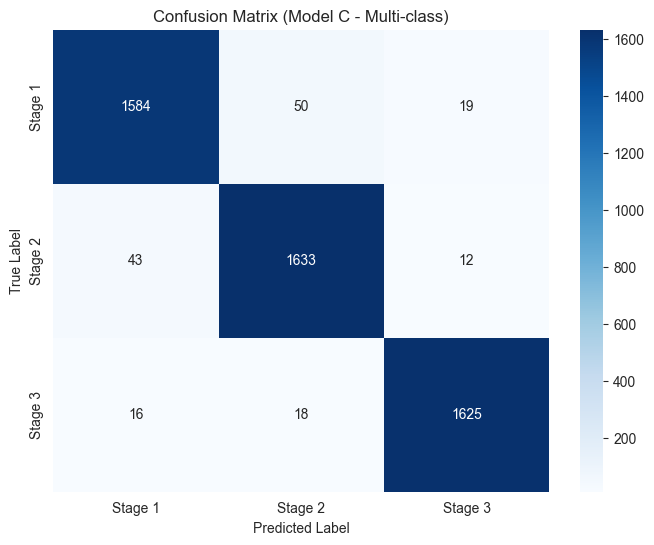

Macro F1-Score: 0.9684


In [47]:
# Final Ensemble (Model C - Multi-class)
model_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb), ('lgbm', model_lgbm)],
    voting='soft'
)

final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble)
])

print("Training Ensemble (Model C - Multi-class)...")
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)

print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred, target_names=['Stage 1', 'Stage 2', 'Stage 3']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stage 1', 'Stage 2', 'Stage 3'], yticklabels=['Stage 1', 'Stage 2', 'Stage 3'])
plt.title('Confusion Matrix (Model C - Multi-class)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Macro F1
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-Score: {f1_macro:.4f}") 

## 6.5. Individual Model Performance Comparison

INDIVIDUAL MODEL PERFORMANCE COMPARISON
\n1️⃣ Random Forest Classifier


  Accuracy: 0.9562
  F1-Score (Macro): 0.9562
\n2️⃣ XGBoost Classifier
  Accuracy: 0.9666
  F1-Score (Macro): 0.9666
\n3️⃣ LightGBM Classifier
  Accuracy: 0.9682
  F1-Score (Macro): 0.9682
\n4️⃣ Voting Ensemble (Soft Voting)
  Accuracy: 0.9684
  F1-Score (Macro): 0.9684
PERFORMANCE COMPARISON TABLE
                 Accuracy  F1-Score (Macro)  F1-Score (Weighted)
Random Forest      0.9562          0.956230             0.956203
XGBoost            0.9666          0.966636             0.966611
LightGBM           0.9682          0.968230             0.968196
Voting Ensemble    0.9684          0.968421             0.968402


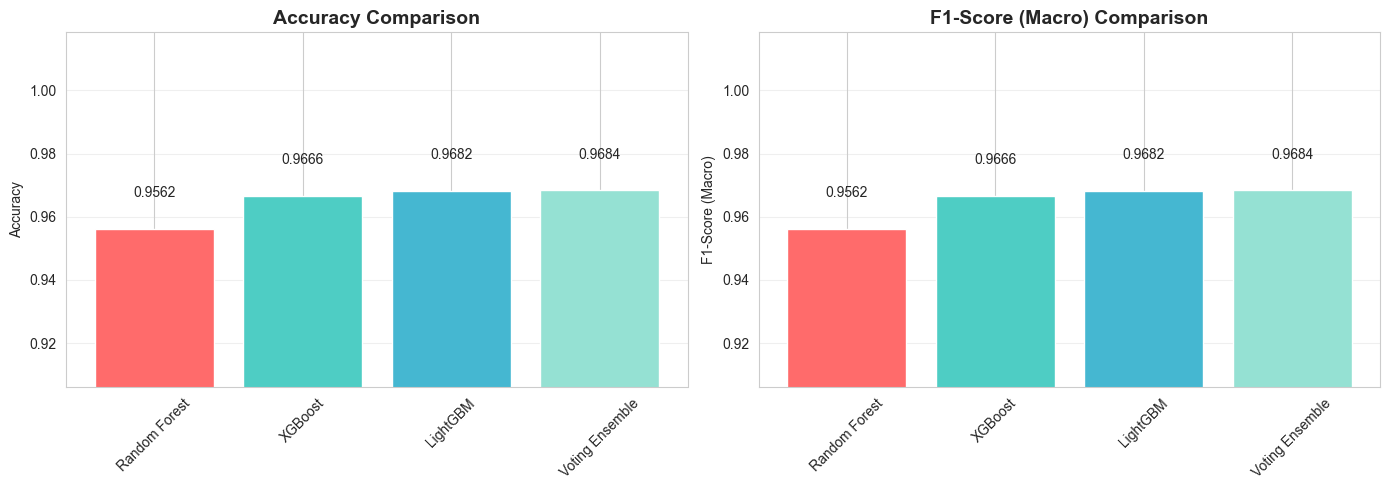

🏆 Best Model: Voting Ensemble (F1-Score: 0.9684)


In [49]:
print("="*70)
print("INDIVIDUAL MODEL PERFORMANCE COMPARISON")
print("="*70)

# Train and evaluate each model individually
individual_results = {}

# 1. Random Forest
print("\\n1️⃣ Random Forest Classifier")
model_rf_individual = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model_rf_individual)
])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

individual_results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1-Score (Macro)': f1_score(y_test, y_pred_rf, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_rf, average='weighted')
}
print(f"  Accuracy: {individual_results['Random Forest']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['Random Forest']['F1-Score (Macro)']:.4f}")

# 2. XGBoost
print("\\n2️⃣ XGBoost Classifier")
model_xgb_individual = XGBClassifier(**best_xgb_params, random_state=42)
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model_xgb_individual)
])
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

individual_results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'F1-Score (Macro)': f1_score(y_test, y_pred_xgb, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_xgb, average='weighted')
}
print(f"  Accuracy: {individual_results['XGBoost']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['XGBoost']['F1-Score (Macro)']:.4f}")

# 3. LightGBM
print("\\n3️⃣ LightGBM Classifier")
model_lgbm_individual = LGBMClassifier(**best_lgbm_params, random_state=42)
pipeline_lgbm = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model_lgbm_individual)
])
pipeline_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipeline_lgbm.predict(X_test)

individual_results['LightGBM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'F1-Score (Macro)': f1_score(y_test, y_pred_lgbm, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_lgbm, average='weighted')
}
print(f"  Accuracy: {individual_results['LightGBM']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['LightGBM']['F1-Score (Macro)']:.4f}")

# 4. Voting Ensemble (from previous section)
print("\\n4️⃣ Voting Ensemble (Soft Voting)")
individual_results['Voting Ensemble'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1-Score (Macro)': f1_score(y_test, y_pred, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred, average='weighted')
}
print(f"  Accuracy: {individual_results['Voting Ensemble']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['Voting Ensemble']['F1-Score (Macro)']:.4f}")

# Comparison Table
print("" + "="*70)
print("PERFORMANCE COMPARISON TABLE")
print("="*70)
comparison_df = pd.DataFrame(individual_results).T
print(comparison_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison_df.index, comparison_df['Accuracy'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3'])
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([comparison_df['Accuracy'].min() - 0.05, comparison_df['Accuracy'].max() + 0.05])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# F1-Score comparison
axes[1].bar(comparison_df.index, comparison_df['F1-Score (Macro)'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3'])
axes[1].set_title('F1-Score (Macro) Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score (Macro)')
axes[1].set_ylim([comparison_df['F1-Score (Macro)'].min() - 0.05, comparison_df['F1-Score (Macro)'].max() + 0.05])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['F1-Score (Macro)']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = comparison_df['F1-Score (Macro)'].idxmax()
best_f1 = comparison_df.loc[best_model_name, 'F1-Score (Macro)']
print(f"🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")

# Store best model name for later use
best_individual_model = best_model_name


## 6.6. Model Saving (for Serving)

In [50]:
print("="*70)
print("SAVING MODELS FOR SERVING")
print("="*70)

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save individual models
print("Saving individual models...")
joblib.dump(pipeline_rf, 'saved_models/model_c_random_forest.pkl')
print("✅ Saved: model_c_random_forest.pkl")

joblib.dump(pipeline_xgb, 'saved_models/model_c_xgboost.pkl')
print("✅ Saved: model_c_xgboost.pkl")

joblib.dump(pipeline_lgbm, 'saved_models/model_c_lightgbm.pkl')
print("✅ Saved: model_c_lightgbm.pkl")

# Save voting ensemble
joblib.dump(final_pipeline, 'saved_models/model_c_voting_ensemble.pkl')
print("✅ Saved: model_c_voting_ensemble.pkl")

# Save preprocessor separately (useful for inference)
joblib.dump(preprocessor, 'saved_models/model_c_preprocessor.pkl')
print("✅ Saved: model_c_preprocessor.pkl")

# Save best params for reproducibility
import json
best_params_dict = {
    'random_forest': best_rf_params,
    'xgboost': best_xgb_params,
    'lightgbm': best_lgbm_params,
    'best_model': best_individual_model
}

with open('saved_models/model_c_best_params.json', 'w') as f:
    json.dump(best_params_dict, f, indent=2)
print("✅ Saved: model_c_best_params.json")

print("" + "="*70)
print("All models saved successfully!")
print("Location: ./saved_models/")
print("="*70)

# Show how to load models
print("To load models for serving:")
print("```python")
print("import joblib")
print("model = joblib.load('saved_models/model_c_voting_ensemble.pkl')")
print("predictions = model.predict(new_data)")
print("```")


SAVING MODELS FOR SERVING
Saving individual models...
✅ Saved: model_c_random_forest.pkl
✅ Saved: model_c_xgboost.pkl
✅ Saved: model_c_lightgbm.pkl
✅ Saved: model_c_voting_ensemble.pkl
✅ Saved: model_c_preprocessor.pkl
✅ Saved: model_c_best_params.json
All models saved successfully!
Location: ./saved_models/
To load models for serving:
```python
import joblib
model = joblib.load('saved_models/model_c_voting_ensemble.pkl')
predictions = model.predict(new_data)
```


## 7. Scaling Method Comparison\n\nCompare performance with different scaling methods: **No Scaling**, **StandardScaler**, **MinMaxScaler**

=== Scaling Method Comparison ===
Comparing: No Scaling, StandardScaler, MinMaxScaler

1️⃣ Training with No Scaling...
  F1: 0.9662, Acc: 0.9662

2️⃣ Training with StandardScaler...
  F1: 0.9684, Acc: 0.9684

3️⃣ Training with MinMaxScaler...
  F1: 0.9674, Acc: 0.9674

SCALING METHOD COMPARISON RESULTS
                      F1  Accuracy
No Scaling      0.966229    0.9662
StandardScaler  0.968438    0.9684
MinMaxScaler    0.967427    0.9674


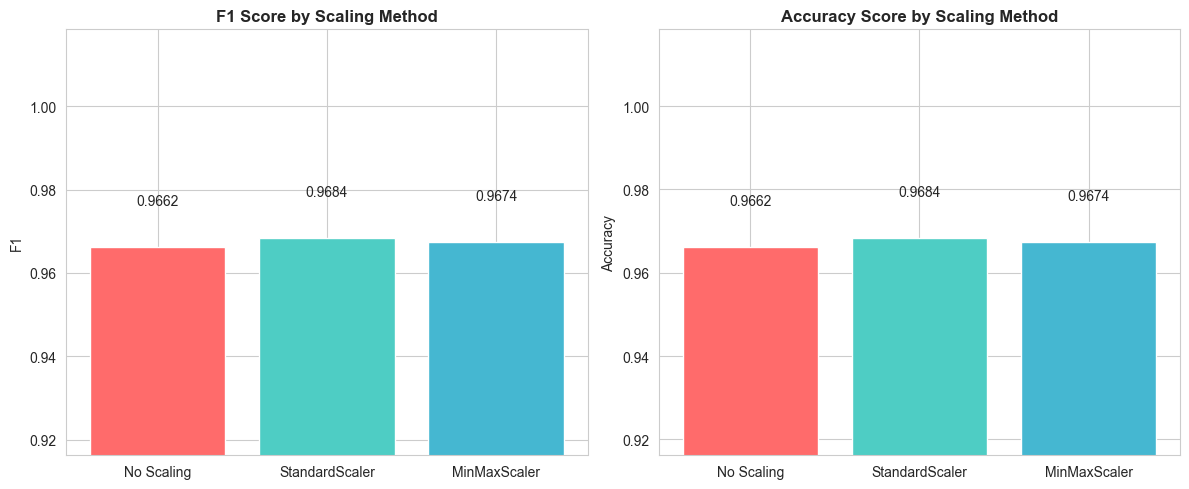


🏆 Best Scaling Method: StandardScaler (F1: 0.9684)


In [51]:
print("=== Scaling Method Comparison ===")
print("Comparing: No Scaling, StandardScaler, MinMaxScaler\n")

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaling_results = {}

# 1. No Scaling (Passthrough)
print("1️⃣ Training with No Scaling...")
preprocessor_none = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model_rf_none = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb_none = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm_none = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble_none = VotingClassifier(
    estimators=[('rf', model_rf_none), ('xgb', model_xgb_none), ('lgbm', model_lgbm_none)],
    voting='soft'
)

pipeline_none = ImbPipeline([
    ('preprocessor', preprocessor_none),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble_none)
])

pipeline_none.fit(X_train, y_train)
y_pred_none = pipeline_none.predict(X_test)

f1_none = f1_score(y_test, y_pred_none, average='macro')
acc_none = accuracy_score(y_test, y_pred_none)

scaling_results['No Scaling'] = {
    'F1': f1_none,
    'Accuracy': acc_none
}

print(f"  F1: {f1_none:.4f}, Acc: {acc_none:.4f}")

# 2. StandardScaler
print("\n2️⃣ Training with StandardScaler...")
preprocessor_std = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model_rf_std = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb_std = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm_std = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble_std = VotingClassifier(
    estimators=[('rf', model_rf_std), ('xgb', model_xgb_std), ('lgbm', model_lgbm_std)],
    voting='soft'
)

pipeline_std = ImbPipeline([
    ('preprocessor', preprocessor_std),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble_std)
])

pipeline_std.fit(X_train, y_train)
y_pred_std = pipeline_std.predict(X_test)

f1_std = f1_score(y_test, y_pred_std, average='macro')
acc_std = accuracy_score(y_test, y_pred_std)

scaling_results['StandardScaler'] = {
    'F1': f1_std,
    'Accuracy': acc_std
}

print(f"  F1: {f1_std:.4f}, Acc: {acc_std:.4f}")

# 3. MinMaxScaler
print("\n3️⃣ Training with MinMaxScaler...")
preprocessor_minmax = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model_rf_mm = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb_mm = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm_mm = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble_mm = VotingClassifier(
    estimators=[('rf', model_rf_mm), ('xgb', model_xgb_mm), ('lgbm', model_lgbm_mm)],
    voting='soft'
)

pipeline_mm = ImbPipeline([
    ('preprocessor', preprocessor_minmax),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble_mm)
])

pipeline_mm.fit(X_train, y_train)
y_pred_mm = pipeline_mm.predict(X_test)

f1_mm = f1_score(y_test, y_pred_mm, average='macro')
acc_mm = accuracy_score(y_test, y_pred_mm)

scaling_results['MinMaxScaler'] = {
    'F1': f1_mm,
    'Accuracy': acc_mm
}

print(f"  F1: {f1_mm:.4f}, Acc: {acc_mm:.4f}")

# Results Table
print("\n" + "="*60)
print("SCALING METHOD COMPARISON RESULTS")
print("="*60)
results_df = pd.DataFrame(scaling_results).T
print(results_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

metrics = ['F1', 'Accuracy']
for idx, metric in enumerate(metrics):
    values = [scaling_results[method][metric] for method in ['No Scaling', 'StandardScaler', 'MinMaxScaler']]
    axes[idx].bar(['No Scaling', 'StandardScaler', 'MinMaxScaler'], values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[idx].set_title(f'{metric} Score by Scaling Method', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([min(values) - 0.05, max(values) + 0.05])
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Best method
best_method = max(scaling_results.items(), key=lambda x: x[1]['F1'])
print(f"\n🏆 Best Scaling Method: {best_method[0]} (F1: {best_method[1]['F1']:.4f})")


## 8. SHAP Analysis (Individual Models)\n\nSHAP analysis for each model (RF, XGB, LGBM) to understand feature importance and contributions.

### 8.1 Random Forest SHAP Analysis

SHAP ANALYSIS - RANDOM FOREST

Total features after transformation: 22


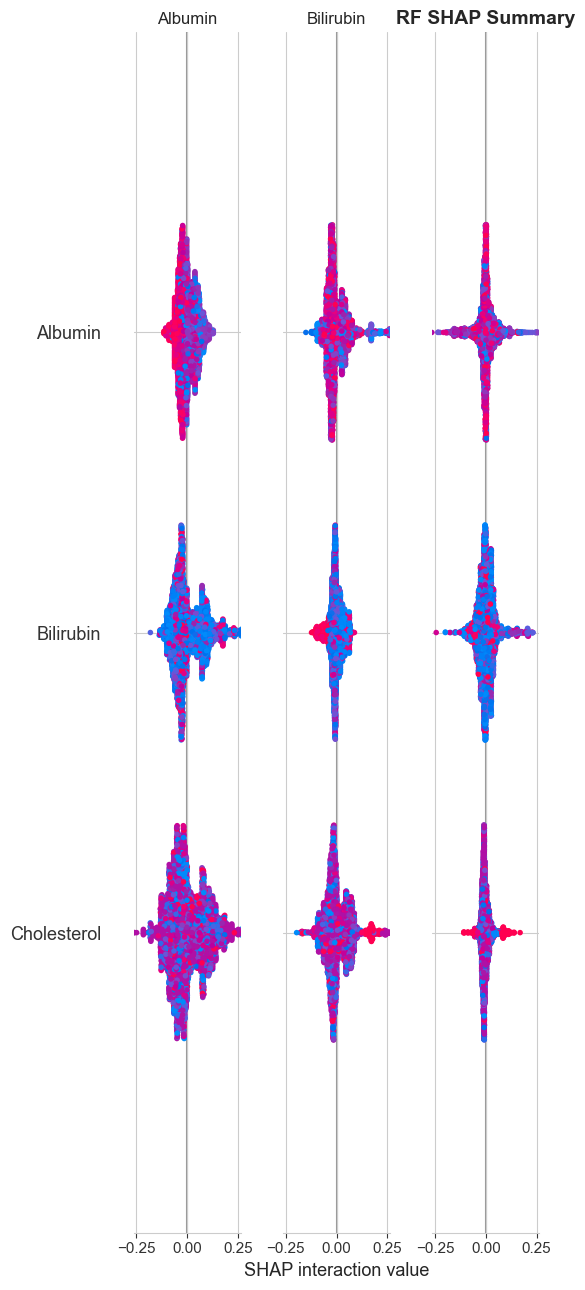


Random Forest SHAP Analysis Complete!


In [52]:
print("="*70)
print("SHAP ANALYSIS - RANDOM FOREST")
print("="*70)

# Train RF model with best params
model_rf_shap = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

# Fit preprocessor and model
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Train model
model_rf_shap.fit(X_train_resampled, y_train_resampled)

# Get feature names after transformation
feature_names_transformed = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        feature_names_transformed.extend(features)
    elif name == 'cat':
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names_transformed.extend(transformer.get_feature_names_out(features))

print(f"\nTotal features after transformation: {len(feature_names_transformed)}")

# SHAP Explainer
explainer_rf = shap.TreeExplainer(model_rf_shap)
shap_values_rf = explainer_rf.shap_values(X_test_transformed)

# For multi-class, shap_values is a list
if isinstance(shap_values_rf, list):
    print(f"Multi-class SHAP values: {len(shap_values_rf)} classes")
    
    # Summary plot for each class
    for class_idx in range(len(shap_values_rf)):
        print(f"\nClass {class_idx} (Stage {class_idx + 1}):")
        shap.summary_plot(shap_values_rf[class_idx], X_test_transformed, 
                         feature_names=feature_names_transformed, 
                         plot_type='bar', show=False, max_display=15)
        plt.title(f'RF SHAP - Class {class_idx} (Stage {class_idx + 1})', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    shap.summary_plot(shap_values_rf, X_test_transformed, 
                     feature_names=feature_names_transformed, show=False, max_display=15)
    plt.title('RF SHAP Summary', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nRandom Forest SHAP Analysis Complete!")


### 8.2 XGBoost SHAP Analysis

SHAP ANALYSIS - XGBOOST


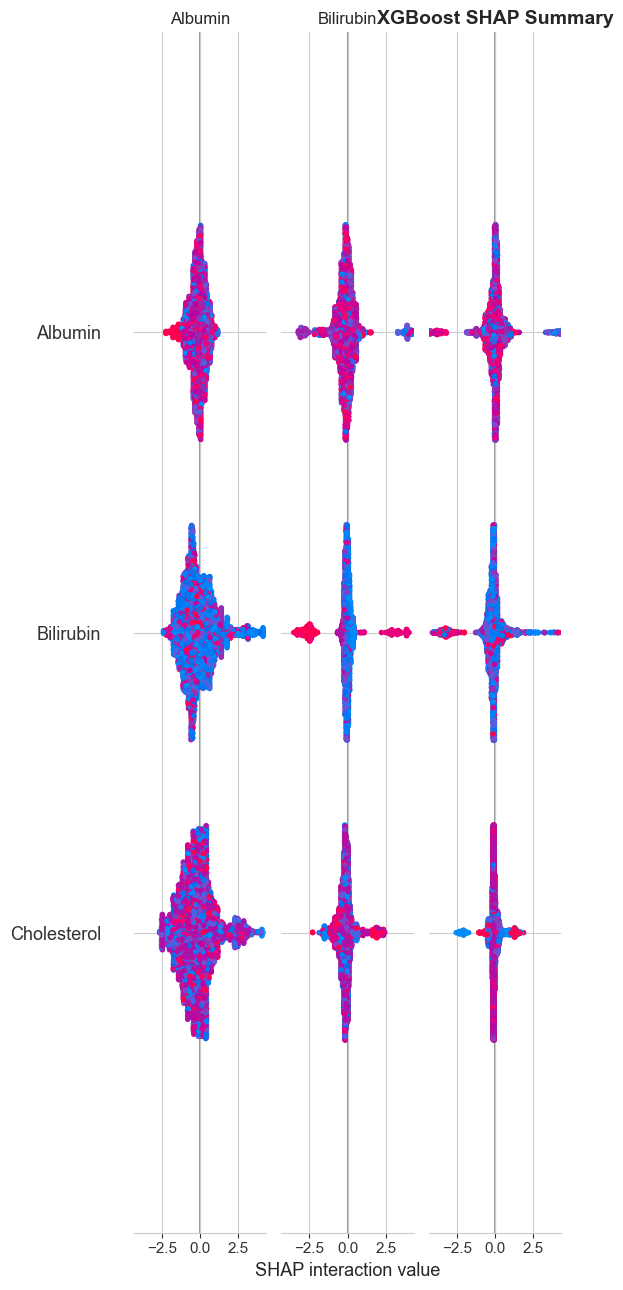


XGBoost SHAP Analysis Complete!


In [53]:
print("="*70)
print("SHAP ANALYSIS - XGBOOST")
print("="*70)

# Train XGB model with best params
model_xgb_shap = XGBClassifier(**best_xgb_params, random_state=42)

# Train model
model_xgb_shap.fit(X_train_resampled, y_train_resampled)

# SHAP Explainer
explainer_xgb = shap.TreeExplainer(model_xgb_shap)
shap_values_xgb = explainer_xgb.shap_values(X_test_transformed)

# For multi-class
if isinstance(shap_values_xgb, list):
    print(f"Multi-class SHAP values: {len(shap_values_xgb)} classes")
    
    for class_idx in range(len(shap_values_xgb)):
        print(f"\nClass {class_idx} (Stage {class_idx + 1}):")
        shap.summary_plot(shap_values_xgb[class_idx], X_test_transformed, 
                         feature_names=feature_names_transformed, 
                         plot_type='bar', show=False, max_display=15)
        plt.title(f'XGBoost SHAP - Class {class_idx} (Stage {class_idx + 1})', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    shap.summary_plot(shap_values_xgb, X_test_transformed, 
                     feature_names=feature_names_transformed, show=False, max_display=15)
    plt.title('XGBoost SHAP Summary', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nXGBoost SHAP Analysis Complete!")


### 8.3 LightGBM SHAP Analysis

SHAP ANALYSIS - LIGHTGBM


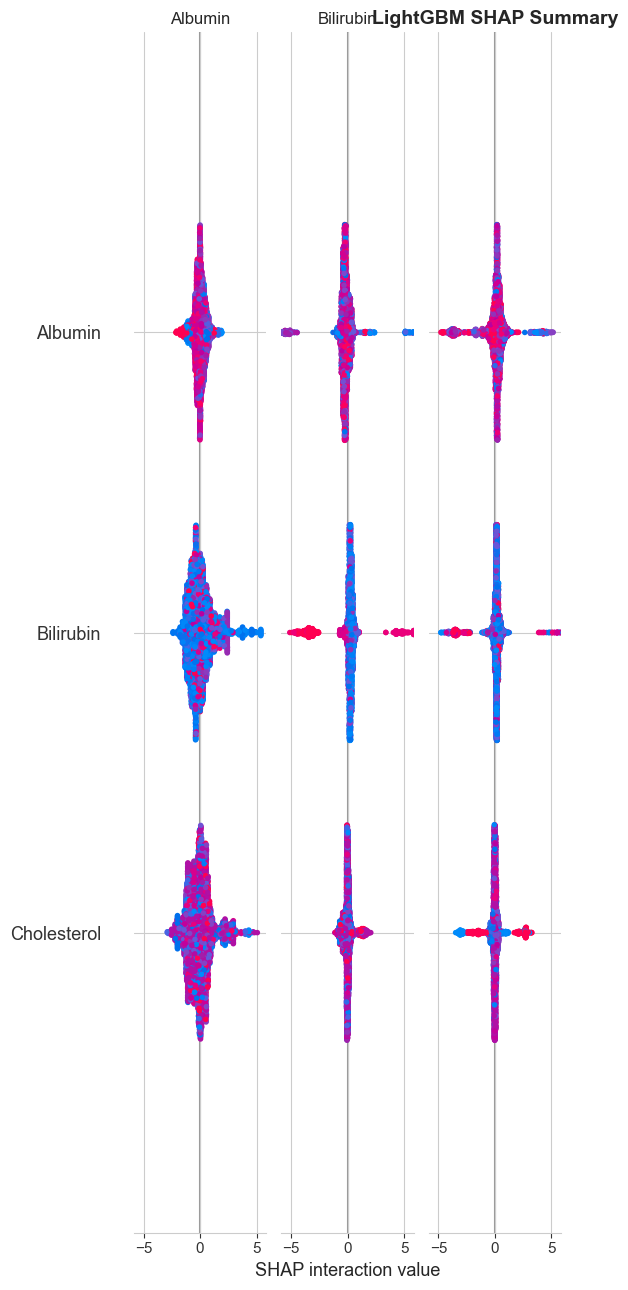


LightGBM SHAP Analysis Complete!


In [54]:
print("="*70)
print("SHAP ANALYSIS - LIGHTGBM")
print("="*70)

# Train LGBM model with best params
model_lgbm_shap = LGBMClassifier(**best_lgbm_params, random_state=42)

# Train model
model_lgbm_shap.fit(X_train_resampled, y_train_resampled)

# SHAP Explainer
explainer_lgbm = shap.TreeExplainer(model_lgbm_shap)
shap_values_lgbm = explainer_lgbm.shap_values(X_test_transformed)

# For multi-class
if isinstance(shap_values_lgbm, list):
    print(f"Multi-class SHAP values: {len(shap_values_lgbm)} classes")
    
    for class_idx in range(len(shap_values_lgbm)):
        print(f"\nClass {class_idx} (Stage {class_idx + 1}):")
        shap.summary_plot(shap_values_lgbm[class_idx], X_test_transformed, 
                         feature_names=feature_names_transformed, 
                         plot_type='bar', show=False, max_display=15)
        plt.title(f'LightGBM SHAP - Class {class_idx} (Stage {class_idx + 1})', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    shap.summary_plot(shap_values_lgbm, X_test_transformed, 
                     feature_names=feature_names_transformed, show=False, max_display=15)
    plt.title('LightGBM SHAP Summary', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nLightGBM SHAP Analysis Complete!")


### 8.4 SHAP Feature Importance Comparison

In [55]:
print("="*70)
print("SHAP FEATURE IMPORTANCE COMPARISON")
print("="*70)

# Extract mean absolute SHAP values for each model
import numpy as np

# For multi-class, average across classes
if isinstance(shap_values_rf, list):
    mean_shap_rf = np.mean([np.abs(shap_values_rf[i]).mean(axis=0) for i in range(len(shap_values_rf))], axis=0)
    mean_shap_xgb = np.mean([np.abs(shap_values_xgb[i]).mean(axis=0) for i in range(len(shap_values_xgb))], axis=0)
    mean_shap_lgbm = np.mean([np.abs(shap_values_lgbm[i]).mean(axis=0) for i in range(len(shap_values_lgbm))], axis=0)
else:
    mean_shap_rf = np.abs(shap_values_rf).mean(axis=0)
    mean_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
    mean_shap_lgbm = np.abs(shap_values_lgbm).mean(axis=0)

# Create comparison DataFrame
# Ensure all arrays have the same length
n_features = len(mean_shap_rf)
print(f"Number of features: {n_features}")
print(f"Feature names length: {len(feature_names_transformed)}")

# If lengths don't match, truncate or pad feature names
if len(feature_names_transformed) != n_features:
    print(f"WARNING: Feature names ({len(feature_names_transformed)}) != SHAP values ({n_features})")
    if len(feature_names_transformed) > n_features:
        feature_names_transformed = feature_names_transformed[:n_features]
    else:
        # Pad with generic names
        feature_names_transformed.extend([f'feature_{i}' for i in range(len(feature_names_transformed), n_features)])

shap_comparison = pd.DataFrame({
    'Feature': feature_names_transformed,
    'RF_SHAP': mean_shap_rf,
    'XGB_SHAP': mean_shap_xgb,
    'LGBM_SHAP': mean_shap_lgbm
})

# Average SHAP across models
shap_comparison['Avg_SHAP'] = shap_comparison[['RF_SHAP', 'XGB_SHAP', 'LGBM_SHAP']].mean(axis=1)
shap_comparison = shap_comparison.sort_values('Avg_SHAP', ascending=False).head(20)

print("\nTop 20 Features by Average SHAP Importance:")
print(shap_comparison)

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(shap_comparison))
width = 0.25

ax.barh(x - width, shap_comparison['RF_SHAP'], width, label='Random Forest', color='#FF6B6B')
ax.barh(x, shap_comparison['XGB_SHAP'], width, label='XGBoost', color='#4ECDC4')
ax.barh(x + width, shap_comparison['LGBM_SHAP'], width, label='LightGBM', color='#45B7D1')

ax.set_yticks(x)
ax.set_yticklabels(shap_comparison['Feature'])
ax.set_xlabel('Mean Absolute SHAP Value', fontsize=12, fontweight='bold')
ax.set_title('SHAP Feature Importance Comparison (Top 20)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SHAP Analysis Complete for All Models!")
print("="*70)


SHAP FEATURE IMPORTANCE COMPARISON
Number of features: 22
Feature names length: 22


ValueError: Per-column arrays must each be 1-dimensional

### 8.5. Single Prediction Explanation (Best Model)\n\nDetailed SHAP explanation for one test sample using the best performing model.

In [ ]:
print("="*70)
print("SINGLE PREDICTION SHAP EXPLANATION - BEST MODEL")
print("="*70)

# Determine which model to use based on best performance
# From section 6.5, we stored best_individual_model
print(f"\nUsing: {best_individual_model}")

# Select the appropriate model and SHAP values
if 'Random Forest' in best_individual_model:
    best_model_for_shap = model_rf_shap
    best_shap_values = shap_values_rf
    model_name = "Random Forest"
elif 'XGBoost' in best_individual_model:
    best_model_for_shap = model_xgb_shap
    best_shap_values = shap_values_xgb
    model_name = "XGBoost"
elif 'LightGBM' in best_individual_model:
    best_model_for_shap = model_lgbm_shap
    best_shap_values = shap_values_lgbm
    model_name = "LightGBM"
else:
    # Default to XGBoost if voting ensemble
    best_model_for_shap = model_xgb_shap
    best_shap_values = shap_values_xgb
    model_name = "XGBoost (from Ensemble)"

print(f"Model selected for explanation: {model_name}")

# Select an interesting sample (e.g., one that's correctly classified with high confidence)
sample_idx = 0  # First test sample

# Get actual and predicted labels
actual_label = y_test.iloc[sample_idx]
predicted_label = best_model_for_shap.predict(X_test_transformed[sample_idx:sample_idx+1])[0]
predicted_proba = best_model_for_shap.predict_proba(X_test_transformed[sample_idx:sample_idx+1])[0]

print(f"\nSample Index: {sample_idx}")
print(f"Actual Stage: {actual_label + 1} (Class {actual_label})")
print(f"Predicted Stage: {predicted_label + 1} (Class {predicted_label})")
print(f"Prediction Probabilities:")
for i, prob in enumerate(predicted_proba):
    print(f"  Stage {i+1}: {prob:.4f}")

# SHAP Waterfall Plot for the predicted class
print(f"\nGenerating SHAP explanation for the prediction...")

# For multi-class, use the predicted class SHAP values
if isinstance(best_shap_values, list):
    # Multi-class: use SHAP values for predicted class
    shap_values_for_sample = best_shap_values[predicted_label][sample_idx]
    expected_value = explainer_rf.expected_value[predicted_label] if 'Random' in model_name else explainer_xgb.expected_value[predicted_label] if 'XGBoost' in model_name else explainer_lgbm.expected_value[predicted_label]
else:
    # Binary or single array
    shap_values_for_sample = best_shap_values[sample_idx]
    expected_value = explainer_rf.expected_value if 'Random' in model_name else explainer_xgb.expected_value if 'XGBoost' in model_name else explainer_lgbm.expected_value

# Waterfall plot
import shap
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_for_sample,
        base_values=expected_value,
        data=X_test_transformed[sample_idx],
        feature_names=feature_names_transformed
    ),
    max_display=15,
    show=False
)
plt.title(f'SHAP Waterfall Plot - {model_name}\nPrediction: Stage {predicted_label + 1} (Actual: Stage {actual_label + 1})', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Force plot (alternative visualization)
print("\nGenerating SHAP Force Plot...")
shap.force_plot(
    expected_value,
    shap_values_for_sample,
    X_test_transformed[sample_idx],
    feature_names=feature_names_transformed,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot - {model_name}', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Single Prediction Explanation Complete!")
print("="*70)

# Interpretation guide
print("\n📊 How to interpret the SHAP Waterfall Plot:")
print("  - The plot shows how each feature contributes to moving the prediction")
print("  - Red bars push the prediction higher (towards higher stage)")
print("  - Blue bars push the prediction lower (towards lower stage)")
print("  - The base value is the average model output")
print("  - Each feature adds or subtracts from this base to reach the final prediction")
